In [ ]:
#| hide
#| eval: false
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#| default_exp callback.data

# Data Callbacks

> Callbacks which work with a learner's data

In [ ]:
#| export
from __future__ import annotations
from fastai.basics import *

In [ ]:
#| hide
from nbdev.showdoc import *
from fastai.test_utils import *

In [ ]:
#| export
class CollectDataCallback(Callback):
    "Collect all batches, along with `pred` and `loss`, into `self.data`. Mainly for testing"
    def before_fit(self): self.data = L()
    def after_batch(self): 
        self.data.append(self.learn.to_detach((self.xb,self.yb,self.pred,self.loss)))

In [ ]:
#| export
@delegates()
class WeightedDL(TfmdDL):
    "Weighted dataloader where `wgts` is used for the training set only"
    def __init__(self, dataset=None, bs=None, wgts=None, **kwargs):
        wgts = array([1.]*len(dataset) if wgts is None else wgts)
        self.wgts = wgts/wgts.sum()
        super().__init__(dataset=dataset, bs=bs, **kwargs)

    def get_idxs(self):
        if self.n==0: return []
        if not self.shuffle: return super().get_idxs()
        return list(np.random.choice(self.n, self.n, p=self.wgts))

In [ ]:
#| export
@patch
@delegates(Datasets.dataloaders)
def weighted_dataloaders(self:Datasets, wgts, bs=64, **kwargs):
    "Create a weighted dataloader `WeightedDL` with `wgts` for the training set"
    xtra_kwargs = [{}] * (self.n_subsets-1)
    return self.dataloaders(bs=bs, dl_type=WeightedDL, dl_kwargs=({'wgts':wgts}, *xtra_kwargs), **kwargs)

In [ ]:
lbls = np.random.randint(0, 2, size=(10)) # Dataset of size 10 (train=8, valid=2)
is_valid = lambda i: i >= 8
dblock = DataBlock(blocks=[CategoryBlock], 
    getters=[lambda i: lbls[i]], splitter=FuncSplitter(is_valid))
dset = dblock.datasets(list(range(10)))
item_tfms = [ToTensor()] 
wgts = range(8) # len(wgts) == 8
dls = dset.weighted_dataloaders(bs=1, wgts=wgts, after_item=item_tfms)

In [ ]:
dls.show_batch() # if len(wgts) != 8, this will fail"

1


In [ ]:
n = 160
dsets = Datasets(torch.arange(n).float())
dls = dsets.weighted_dataloaders(wgts=range(n), bs=16)
learn = synth_learner(data=dls, cbs=CollectDataCallback)

[0, nan, None, '00:00']


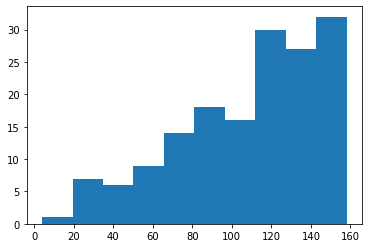

In [ ]:
learn.fit(1)
t = concat(*learn.collect_data.data.itemgot(0,0))
plt.hist(t.numpy());

In [ ]:
#| export
@patch
@delegates(Datasets.weighted_dataloaders)
def weighted_dataloaders(self:DataBlock, source, wgts, bs=64, verbose:bool=False, **kwargs):
    "Create a weighted dataloader `WeightedDL` with `wgts` for the dataset"
    dss = self.datasets(source, verbose=verbose)
    if not hasattr(wgts, '__array__'): wgts = np.array(wgts)
    trn_wgts = wgts[dss.splits[0]]
    return dss.weighted_dataloaders(trn_wgts, bs=bs, after_batch=self.batch_tfms, after_item=self.item_tfms, **kwargs)

In [ ]:
dls = dblock.weighted_dataloaders(list(range(10)), wgts, bs=1)
dls.show_batch()

0


In [ ]:
#| export
@delegates()
class PartialDL(TfmdDL):
    "Select randomly partial quantity of data at each epoch"
    def __init__(self, dataset=None, bs=None, partial_n=None, **kwargs):
        super().__init__(dataset=dataset, bs=bs, **kwargs)
        self.partial_n = min(partial_n, self.n) if partial_n else None

    def get_idxs(self):
        if self.partial_n is None: return super().get_idxs()
        return list(np.random.choice(self.n, self.partial_n, replace=False))

    def __len__(self):
        if self.partial_n is None: return super().__len__()
        return self.partial_n//self.bs + (0 if self.drop_last or self.partial_n%self.bs==0 else 1)

In [ ]:
#| export
@patch
@delegates(Datasets.dataloaders)
def partial_dataloaders(self:FilteredBase, partial_n, bs=64, **kwargs):
    "Create a partial dataloader `PartialDL` for the training set"
    xtra_kwargs = [{}] * (self.n_subsets-1)
    return self.dataloaders(bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs), **kwargs)

In [ ]:
dls = dsets.partial_dataloaders(partial_n=32, bs=16)

In [ ]:
assert len(dls[0])==2
for batch in dls[0]:
    assert len(batch[0])==16

## Export -

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()